In [1]:
from data.datasets import VOCDatasets
from matplotlib import pyplot as plt
import cv2
import numpy as np
import random
from PIL import Image
import torch

In [2]:
def draw_box(img,boxlist):
    box = boxlist.box
    label = boxlist.get_field('labels')
    for b,l in zip(box,label):
        p1 = (int(b[0]),int(b[1]))
        p2 = (int(b[2]),int(b[3]))
        #print(l) 
        cv2.rectangle(img,p1,p2,(255,0,0),2)
    
    return img

In [3]:
def cal_max_overlap(box1,box2):
    # get overlap 
    lt = np.maximum(box1[None, :2], box2[:, :2])  # [N,2]
    rb = np.minimum(box1[None, 2:], box2[:, 2:])  # [N,2]

    TO_REMOVE = 1
    wh = np.clip(rb - lt ,TO_REMOVE,None)  # [N,2]
    inter = wh[:, 0] * wh[:, 1]  # [N]
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    
    iou = inter / (area1 + area2 - inter)
    print(iou)
    return np.max(iou)


In [4]:
dataset = VOCDatasets('./train.txt',train=True)
print(dataset[0]['boxlist'].box)
print(dataset[0]['img'].shape)


[[257.4850296  124.08483228 500.         333.        ]]
(333, 500, 3)


500 375
(500, 375)


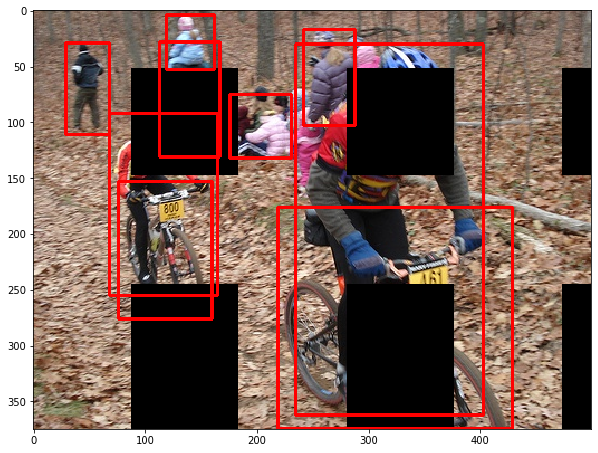

In [9]:
idx = 78

meta = dataset[idx]
#print(np.max(meta['img']))

print(meta['img_width'],meta['img_height'])
print(meta['boxlist'].size)
img = draw_box(meta['img'],meta['boxlist'])
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


In [8]:
def letterbox(img, new_shape=(416, 416), color=(128, 128, 128),
              auto=True, scaleFill=False, scaleup=True, interp=cv2.INTER_AREA):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = max(new_shape) / max(shape)
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = new_shape
        ratio = new_shape[0] / shape[1], new_shape[1] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=interp)  # INTER_AREA is better, INTER_LINEAR is faster
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)

(288, 416, 3)
(0.832, 0.832)
(0.0, 5.5)


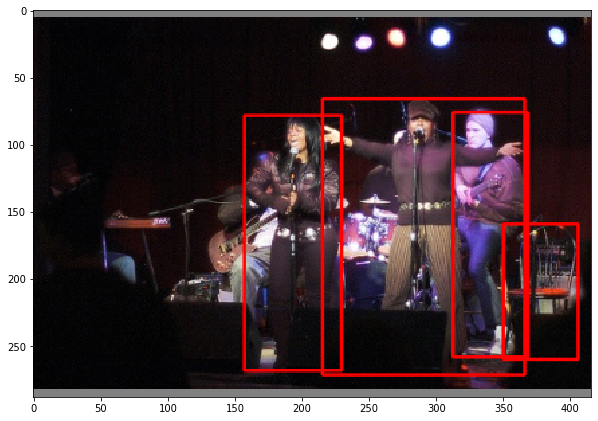

In [7]:
img,ratio,diff=letterbox(meta['img'])
print(img.shape)
print(ratio)
print(diff)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()


In [29]:
class Grid(object):
    def __init__(self, use_h, use_w, rotate = 1, offset=False, ratio = 0.5, mode=0, prob = 1.):
        self.use_h = use_h
        self.use_w = use_w
        self.rotate = rotate
        self.offset = offset
        self.ratio = ratio
        self.mode=mode
        self.st_prob = prob
        self.prob = prob

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * epoch / max_epoch

    def __call__(self, img, label):
        if np.random.rand() > self.prob:
            return img, label
        h = img.size(1)
        w = img.size(2)
        self.d1 = 2
        self.d2 = min(h, w)
        hh = int(1.5*h)
        ww = int(1.5*w)
        d = np.random.randint(self.d1, self.d2)
        #d = self.d
#        self.l = int(d*self.ratio+0.5)
        if self.ratio == 1:
            self.l = np.random.randint(1, d)
        else:
            self.l = min(max(int(d*self.ratio+0.5),1),d-1)
        mask = np.ones((hh, ww), np.float32)
        st_h = np.random.randint(d)
        st_w = np.random.randint(d)
        if self.use_h:
            for i in range(hh//d):
                s = d*i + st_h
                t = min(s+self.l, hh)
                mask[s:t,:] *= 0
        if self.use_w:
            for i in range(ww//d):
                s = d*i + st_w
                t = min(s+self.l, ww)
                mask[:,s:t] *= 0
       
        r = np.random.randint(self.rotate)
        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
#        mask = 1*(np.random.randint(0,3,[hh,ww])>0)
        mask = mask[(hh-h)//2:(hh-h)//2+h, (ww-w)//2:(ww-w)//2+w]

        mask = torch.from_numpy(mask).float()
        if self.mode == 1:
            mask = 1-mask

        mask = mask.expand_as(img)
        if self.offset:
            offset = torch.from_numpy(2 * (np.random.rand(h,w) - 0.5)).float()
            offset = (1 - mask) * offset
            img = img * mask + offset
        else:
            img = img * mask 

        return img, label


In [30]:
grid = Grid(True,True,1,0,0.5,1,0.7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500 375
(500, 375)
torch.Size([3, 375, 500])


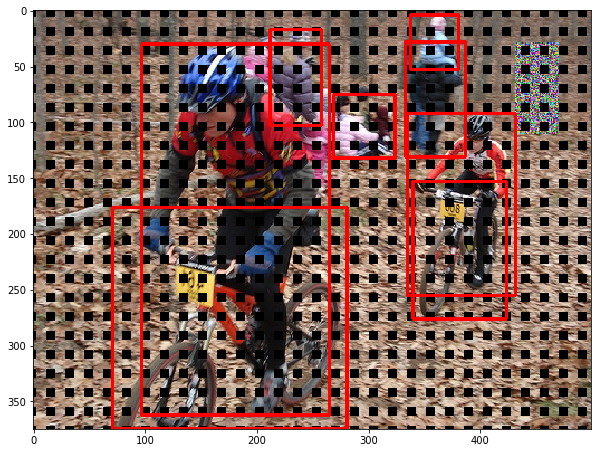

In [43]:
idx = 78

meta = dataset[idx]
#print(np.max(meta['img']))

print(meta['img_width'],meta['img_height'])
print(meta['boxlist'].size)
img = meta['img']
label = meta['boxlist']

img = torch.from_numpy(img)/255.
img = img.permute((2,0,1))
print(img.shape)

img,label = grid(img,label)
img = img.permute((1,2,0))
img = img.numpy()



img = draw_box(img,label)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

